<h1 style='text-align: center;'> MTMW14 Project 1: Recharge Oscillator </h1>
<h2 style='text-align: center;'> Student ID: 31827379 </h2>
    
### 1. Introduction
 
In this project, we implement the ocean recharge oscillator, a simplified model for El Niño Southern Oscillation (ENSO) based on the work of Fei-Fei Jin (1997a). The model reflects the idea that, before an El Niño event, strong easterly trade winds cause warm water to accumulate (recharge) in the equatorial western Pacific. This stored heat content is then released through equatorial Kelvin waves in the thermocline, influencing sea surface temperature (SST) anomalies in the eastern Pacific ($T_E$) and thermocline depth in the western Pacific ($h_W$). The interaction between these two variables leads to an oscillatory pattern, resulting in the recurrent ENSO cycle with transitions between warm and cold phases. This system is represented by two coupled ordinary differential equations, given in Equations 1 and 2.

\begin{align} 
\frac{dh_W}{dt} &= -r h_W - \alpha bT_E - \alpha \xi_1 \\
\frac{dT_E}{dt} &= RT_E + \gamma h_W - e_n (h_W + bT_E)^3 + \gamma \xi_1 + \xi_2
\end{align}

Equation 1 outlines the changes in thermocline depth in the equatorial western Pacific, featuring a damping term ($r$) representing upper ocean damping, wind-forced variations ($\alpha bT_E$), and random wind stress effects ($\alpha \xi_1$). Equation 2 governs changes in the eastern Pacific SST anomaly, involving a damping rate ($c$), the Bjerknes positive feedback ($R=\gamma b - c$), and stochastic wind stress and heating contributions ($\gamma \xi_1$ and $\xi_2$, respectively). The non-linear dependence of the SST anomaly on the thermocline depth is also included for non-zero values of $e_n$. The reader is referred to Fei-Fei Jin (1997a) for a comprehensive explanation of these parameters.

In the absence of stochastic heating or wind stress ($\xi_1$, $\xi_2=0$), and without any non-linearity in the system ($e_n=0$), the above model reduces to a coupled linear system of equations. In this case, the growth-rate of the oscillation is given by $(R - r)/2$. We will first consider this linear case. The initial conditions for this model are taken to be $T_E=1.125$K and $h_W=0$ (January), and they are non-dimensionalised by $7.5$K and $150$m respectively. Any time parameters and the time-step are further non-dimensionalised by a factor of 2 months. The coupling parameter $\mu$ is set to a critical value of $2/3$; it is shown in Jin (1997a) that this produces a stable oscillation, with frequency $\omega = \sqrt{3/32}$, corresponding to a period of approximately 41 months. Unless specified otherwise, the time step is set to $\Delta t=1$ day.

In [1]:
from main import *

### 2. Task A: the neutral linear (deterministic) ROM and stability analysis

We begin with a stability analysis to determine a suitable numerical scheme with which to continue. Schemes considered are the Euler, modified Euler (Matsuno), Trapezoidal, Heun and Fourth-order Runge-Kutte (RK4) numerical schemes (further details in Appendix A). We proceed with a 2D Von Neuman stability analysis by rearranging discretised versions of Equations 1 and 2 into the following form.

\begin{align}
\begin{bmatrix} h_{w}^{n+1} \\ T_{E}^{n+1} \end{bmatrix} = P \begin{bmatrix} h_{w}^{n} \\ T_{E}^{n} \end{bmatrix}
\end{align}

In Equation 3, $P$ is the amplification matrix and is unique for each numerical scheme (shown in Appendix B). The largest of the two eigenvalues of $P$ is the spectral radius $\rho$, and stable schemes are identified when $\vert \rho \vert \leq 1$.

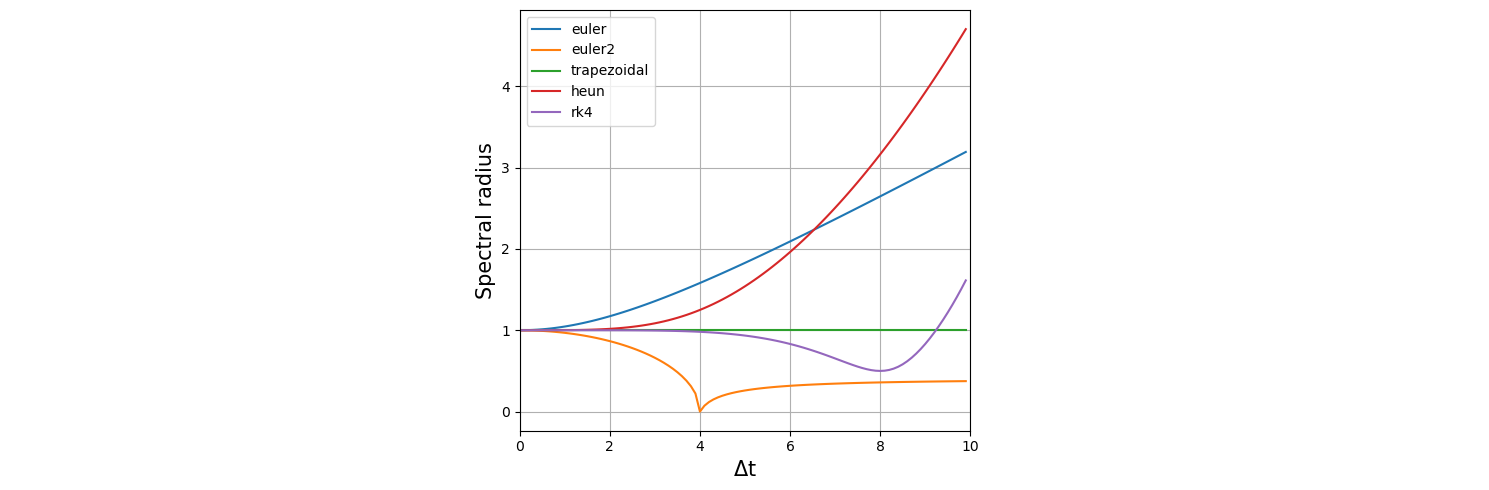

In [2]:
stabilityAnalysis()

Figure 3: Absolute values of spectral radius ($\rho$) plotted for each candidate numerical scheme for values of $\Delta t$ ranging from $0$ to $10$ months. Stability is identified for $\vert \rho \vert \leq 1$.

Figure 3 shows the values of $\rho$ plotted for each of the candidate schemes with time steps between $0$ and $10$ (20 months). The Euler scheme is unstable even at very small time steps, and the Matsuno scheme (euler2) is excessively damping. Beyond $\Delta t=4$ (8 months) the damping behaviour of the scheme decreases and appears to stabilise slowly. The Heun scheme is second-order accurate but becomes unstable for $\Delta t \approx 2$ (4 months).

The Trapezoidal scheme is neutrally stable for all time steps considered, and therefore appears to be the most suitable scheme for the linear form of Equations 1 and 2. This scheme is second-order accurate, but is implicit and requires the solution of a matrix equation at each iteration, making it computationally expensive. Furthermore, if non-linearity is turned on ($e_n \neq 0$) then this additional term must be dealt with. This can be done either by treating it explicitly (which could lead to instability), or by including an iterative predicter step similar to the Heun scheme with which to treat the terms included in the non-linearity. 

The RK4 scheme is neutrally stable for much larger values of $\Delta t$ compared to the Euler and Heun methods. Beyond $\Delta t=4$ the scheme becomes slightly damping and then becomes unstable beyond $\Delta t \approx 9$ (18 months). Therefore, much larger time steps can be used for this scheme compared to the others, with the exception of the Trapezoidal scheme. It is also relatively expensive (and somewhat slow) since it requires four sequential function evaluations at each iteration to calculate the new time step solution. 

In this project, the RK4 scheme will be used, since it provides an adequate balance between stability and computational expense, and is additionally 4th order accurate. If the computational expense were significant, the Heun scheme would be used instead, since it is second-order accurate and stable up to $\Delta t \approx 2$ months. However, this is not the case in our application. If time steps of  $\Delta t \geq 9$ were needed, we would perhaps consider a more efficient time scheme, such as a Semi-Lagrangian scheme. Some ENSO characteristics occur on smaller time scales than $9$ months and we would lose information at larger time steps, so this was not considered further. Figure 1 shows the model run for one period ($\approx 41$ months) and with a time step of $\Delta t = 1$ day.

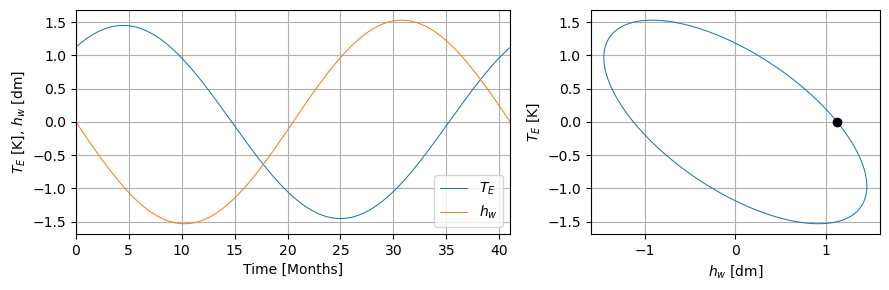

In [3]:
runSolver(numPeriods=1, dt=1/30, en=0., mu=2/3)

Figure 4: Time series (left) for SST anomaly and thermocline depth, and their corresponding trajectory plot (right) for the RK4 scheme.

Figure 4 shows the stable solutions obtained with the RK4 scheme. The solutions now oscillate with a fixed amplitude, and the phase trajectories exhibit an elliptical orbit and rotate clockwise. The ellipticity is due to the phase difference between the thermocline and SST anomalies. Both solutions oscillate with a period of 41.5 months.

### 3. Task B: testing ROM behaviour around sub-critical and super-critical settings of the coupling parameter

The relative coupling parameter ($\mu$) is included in Equations 1 and 2 through $b=b_0\mu$, where $b_0$ is the high-end estimation of $b$. It is defined such that when $\mu=0$ the equations become uncoupled, and an increasing $\mu$ corresponds to an increase in coupling strength. In Jin (1997a), it was found that when $\mu=2/3$, the growth rate is $(R - r)/2=0$ and the critical frequency is $\omega = \sqrt{3/32}$ - the model gives perfect harmonic oscillations. Here, we consider a range of values for $\mu$ above and below this critical value for a simulation time of 5 periods.

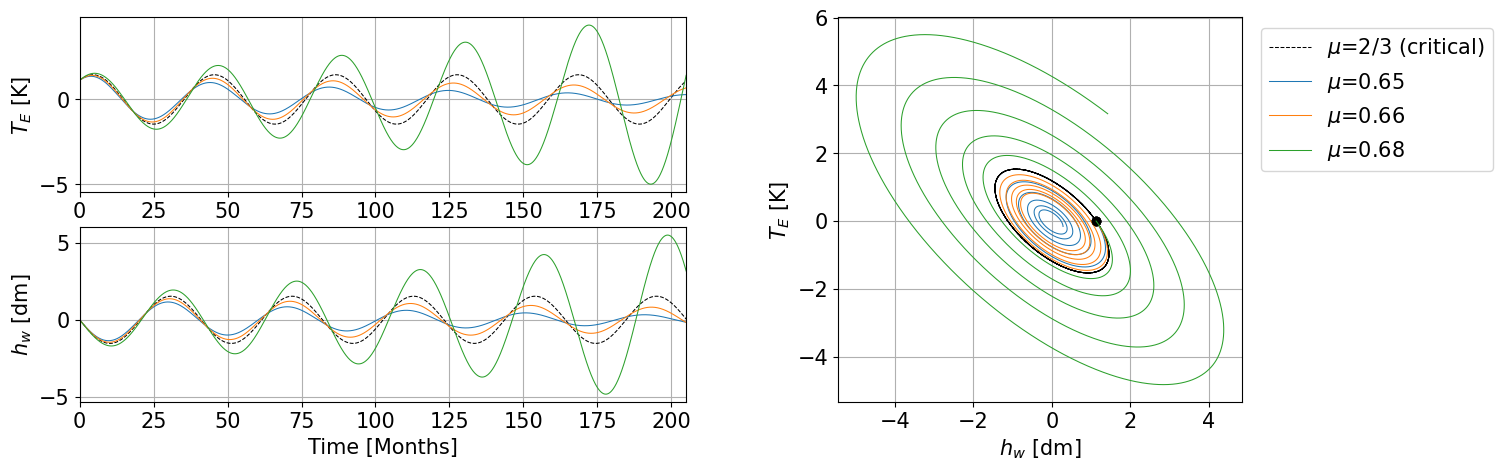

In [4]:
runTaskB(numPeriods=5)

Figure 5: Time series and trajectory plots for the model with different values of coupling parameter. The solutions with the coupling parameter set to its critical value is shown dashed for reference.

From Figure 5 it can be seen that in cases of $\mu < 2/3$ (sub-critical), the solutions continue to oscillate, but are damping and become more strongly damping as the value of the coupling parameter is decreased. This occurs because the linear growth rate becomes negative, such that the oceanic damping rate becomes larger than the Bjerkness feedback parameter. Physically, this means that as the atmosphere and ocean become less coupled, damping (and energy loss) in the upper ocean occurs faster than can be recovered due the Bjerkness feedback process, and the oscillation subsequently dies out. In this regime, it also seems as though the oscillations lag behind that of the critical case, and would therefore events would occur earlier in the year. However, the period of oscillation appears to be unaffected by the value of the coupling parameter.

The opposite is true in cases of $\mu > 2/3$ (super-critical), where the solutions quickly grow. In this case, the linear growth rate becomes positive, and the Bjerkness feedback process overtakes the oceanic damping rate. This leads to an unstable growth in the amplitude of the oscillations. Due to the differences in behaviour around the critical value of the coupling parameter, this leads to a Hopf bifurcation from the climate state around which the model has been linearised.

### 4. Task C: extending ROM to include the impact of non-linearity

One of the strongest non-linearities in the tropical Pacific ocean-atmosphere system is the relationship between the subsurface temperature and the thermocline depth. This relationship can be parameterized by a cubic term which is included in Equation 2. In this section, the non-linearity parameter ($e_n$) is varied and the coupling parameter is reset to its critical value.

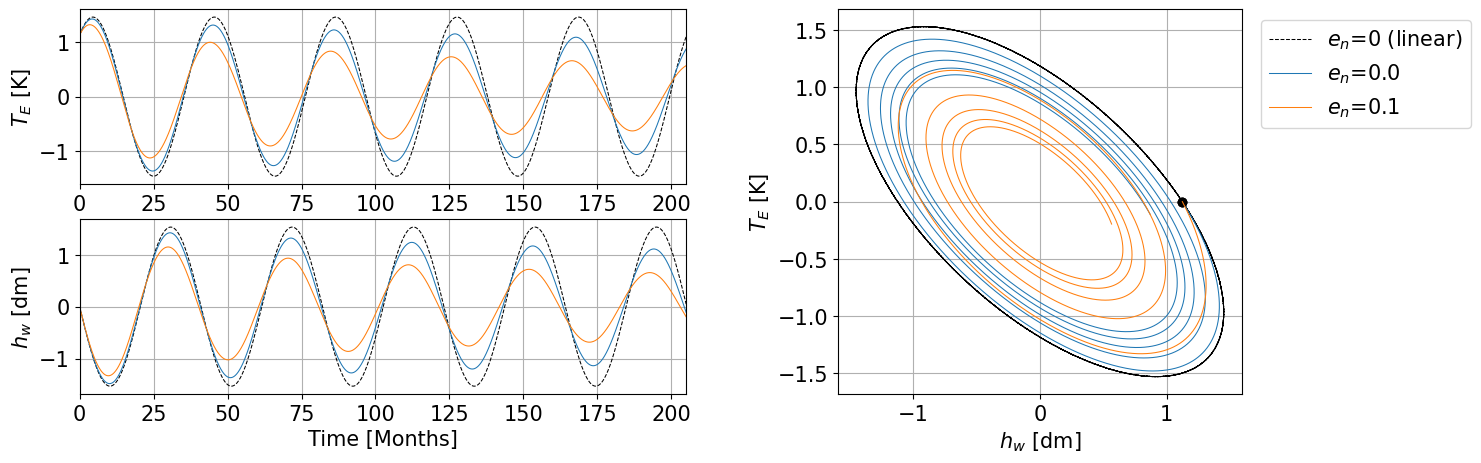

In [5]:
runTaskCPart1(numPeriods=5)

Figure 6: The effects of non-linearity are explored on the solutions to Equations 1 and 2, and are compared to the linear case. In this case, the coupling parameter is set to its critical value of $\mu=2/3$.

Figure 6 shows that the effect of the non-linear term is to damp the oscillations, and this damping effect gets stronger as the non-linearity is increased. In Jin (1997a), it is explained that this occurs because of the affects of non-linearity on the thermocline feedback - a shallow or deep thermocline will not result in a linear increase in the SST temperature anomaly. As such, the damping processes overtake the positive feedback processes (such as Bjerknes feedback), and the oscillations decay.

It is interesting to observe how the non-linearity affects a system with super-critical values of $\mu$, which would otherwise be unstable. Figure 7 shows the time series and phase plots for a system with $e_n=0.1$, and coupling parameter $\mu=0.75$.

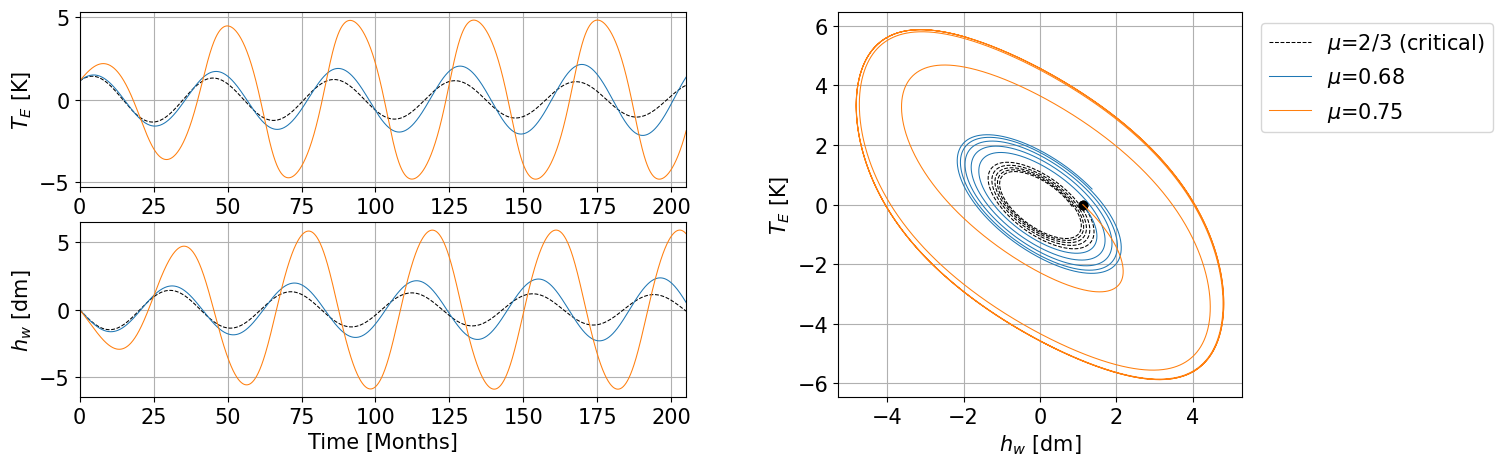

In [6]:
runTaskCPart2(numPeriods=5)

Figure 7: The solutions to the non-linear model ($e_n=0.1$) for different supercritical values of $\mu$.

The effect of non-linearity on the model with supercritical values of the coupling parameter ($\mu > 2/3$) is to limit the growth rate of the oscillations. The case of $\mu=0.68$ in Figure 7 can be compared with the linear case in Figure 5, where it is clear that the amplitude of the oscillations are much larger without the affect of non-linearity. In fact, the oscillations appear to eventually settle into a finite amplitude oscillation, as depicted for $\mu=0.75$. At this point, the solution exhibits harmonic oscillation, although the phase trajectories are not perfectly elliptical as they were in the linear system. 

Increasing $e_n$ acts to increase the amplitude of the oscillations, and as such this system is considered to be "self-excited", and the model is able to sustain its own oscillations. An initially dominant Bjerknes positive feedback (from a supercritical $\mu$) causes the amplitudes of the oscillation to grow, and eventually is balanced by the combined damping affects in the ocean and atmosphere. In addition, the period of the oscillations appear to increase slightly with increasing $\mu$.

### 5. Task D: test the self-excitation hypothesis
The seasonal cycle may be introduced into the model by incorporating it into the ocean-atmosphere coupling parameter, as demonstrated in Galanti and Tziperman (2000). This modified version is given in Equation 4.

\begin{align}
\mu = \mu_0 \left(1 + \mu_{\text{ann}} \cos\left(\frac{2\pi t}{\tau} - \frac{5\pi}{6}\right)\right)
\end{align}

Annual changes in $\mu$ occur due to seasonal variations in both mean SST and wind divergence (Tziperman et al. 1997). Equation 4 takes this into account such that maximum coupling occurs in the middle of May, and minimum coupling in the middle of November. In this section, the impacts of a varying $\mu$ are considered.

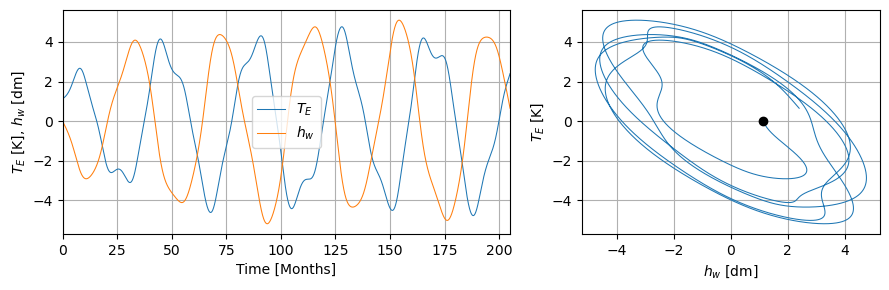

In [7]:
runSolver(numPeriods=5, dt=1/30, en=0.1, mu=0.75, annualCycling=True) # mu = mu0 in this case.

Figure 8: Time series and phase trajectories for a model with annually varying $\mu$. There are no external forcings, and the model includes a non-linear term with $e_n=0.1$.

Figure 8 shows the solutions continue to oscillate, although with more irregularity than the case without annual cycling. As before, the oscillations exhibit an initial growth period. Afterwards, however, the amplitudes for both the SST anomaly and the thermocline depth are not fixed, and vary between events. This variation in amplitude can be explained by considering that the coupling parameter varies between sub-critical and super-critical values throughout the year, resulting in periods of growth and decay during this time. When the coupling parameter is super-critical, the non-linear term acts to limit the unstable growth (see Figure 9). Like in Figure 7, this system can be described as "self-excited".

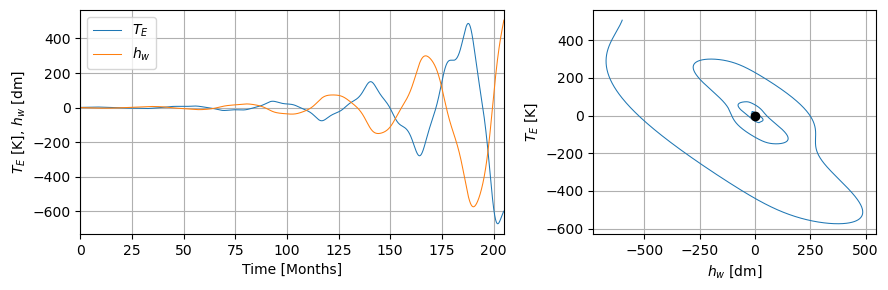

In [8]:
runSolver(numPeriods=5, dt=1/30, en=0., mu=0.75, annualCycling=True) # mu = mu0 in this case.

Figure 9: Time series and phase trajectories for a model with the same settings as Figure 8 but without the addition of non-linearity ($e_n=0$).

### 6. Task E: test the stochastic initiation hypotheses by adding noisy wind forcing to the linear model

In this section we consider the effect of stochastic wind forcing on the solutions, which represent the effects of fast, atmospheric wind anomalies. This wind forcing term is defined in Equation 5.

\begin{align}
\xi_1 = f_{\text{ann}} \cos\left(\frac{2\pi t}{\tau}\right) + \frac{f_{\text{ran}}W}{\tau_{\text{cor}}\Delta t}
\end{align}

This expression for wind forcing contains both an annual cycling term (amplitude determined by $f_{ann}$) and random noise term (described by $f_{ran}$). We first attempt to isolate the behaviour of each of these two terms when the annual cycling of the coupling parameter is turned off. The value of $f_{ran}$ is set to zero and the solutions are compared to the case when $f_{ran}=0.2$. In addition, the effect of time step is analysed by switching $\Delta t$ from 1 day to half a day. The total runtime of the solution is set to 15 periods to observe the behaviour over a sufficient amount of time.

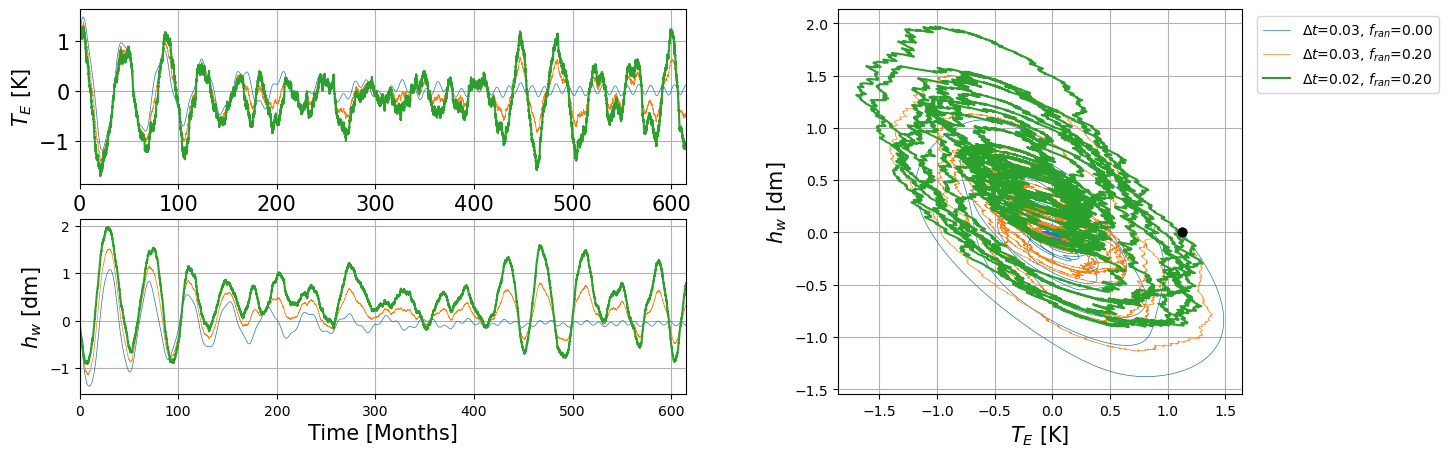

In [9]:
runTaskE(mu=0.65)

Figure 10: Time series and trajectories for the model with different values of $f_{ran}$ and $\Delta t$. Annual cycling in the coupling parameter is turned off, and is set as $\mu=0.65$ (sub-critical).#

Figure 10 shows the oscillatory solutions for a varying $f_{ran}$ and $\Delta t$ and a sub-critical coupling parameter. In the case where the noisy wind stress has been turned off ($f_{ran}=0$) but is permitted to vary annually ($f_{ann}\neq0$), it is seen that the solutions eventually settle to a stable oscillation with amplitude determined by the $f_{ann}$ term following an initial period of decay. During this decay period, the events are irregular and vary in frequency. The period of this oscillation is on the timescale of $\tau$.

The effect of the $f_{ann}$ term in Equation 5 is to prevent full decay by providing a lower limit to the amplitude. By comparing these solutions to the case with $f_{ran}=0.2$ for the same time step (orange), it can be seen that the random wind stress term introduces local fluctuations in both the SST anomaly and thermocline depth on the time scale of $\tau_{corr}$. This random term additionally acts to fluctuate the amplitude of both solutions between growth and decay, and irregularities associated with these events are much greater than those without the random wind stress term, both in amplitude and frequency. When the time step is decreased to $\Delta t=1/2$ a day, the behaviour of the fluctuations is the same but the amplitude grows. Overall, the oscillations exhibited by these solutions appear to be sustained by noise. In this regime we can say that noisy and seasonal fluctuations in equatorial wind sustain ENSO when it would otherwise decay.

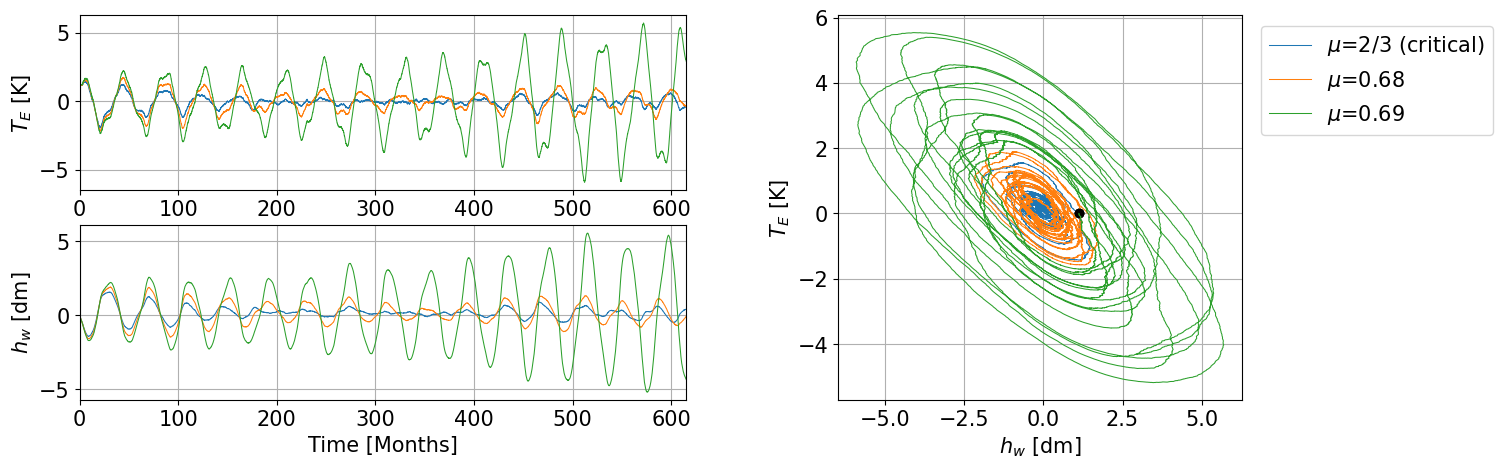

In [10]:
runTaskEAnnualCycling(numPeriods=15, dt=1/30)

Figure 12: Time series and trajectories for the model with different values of $\mu_{0}$. Annual cycling in the coupling parameter has been turned on. 

Figure 12 shows the system with annual cycling in the coupling parameter turned on. The amplitudes for all values of $\mu_0$ appear to grow and decay periodically, where higher values of $\mu_0$ correspond to higher upper limits in amplitude of the solutions, as well as larger periods.

### 7. Task F

The effects of stochastic wind forcing from Task E are now considered in tandem with the effects of non-linearity (with $e_n=0.1$). The time step is reset to $\Delta t=1$ day and the annual cycling is turned on for the coupling parameter such that $\mu_0=0.69$. 

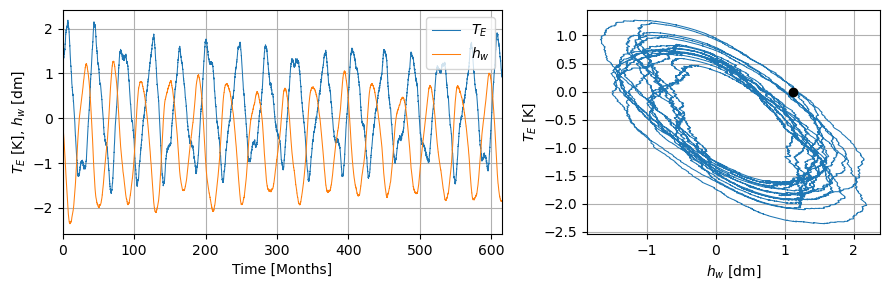

In [11]:
runSolver(numPeriods=15, dt=1/30, en=0.1, mu=0.69, annualCycling=True, windForcing=True) # mu = mu0 in this case.

Figure 13: Time series and trajectories for the model with $\mu_{0}=0.69$. Annual cycling in the coupling parameter has been turned on and the model is non-linear with $e_n=0.1$.

Figure 13 can be compared to the linear case with $\mu_0=0.69$ in Figure 12. The amplitudes of the oscillations for the non-linear case are much smaller, confirming that the effect of the non-linearity is to prevent unstable growth by providing an upper limit to the amplitude. 

### 8. Task G: Ensemble

In this section we perform an ensemble run to check the model's sensitivity to initial conditions and to therefore find evidence of chaos in the system. The initial conditions of each ensemble member are perturbed slightly with random noise (less than $10\%$ of their respective amplitude ranges), and the model is then run for 15 periods. The perturbations for the SST anomaly are limited to $\pm 0.5$K and the thermocline depth is varied between $\pm 5$m. Wind forcing and annual cycling for the coupling parameter are turned on, the non-linearity is set to $e_n=0.1$ and $\mu_0=0.75$.

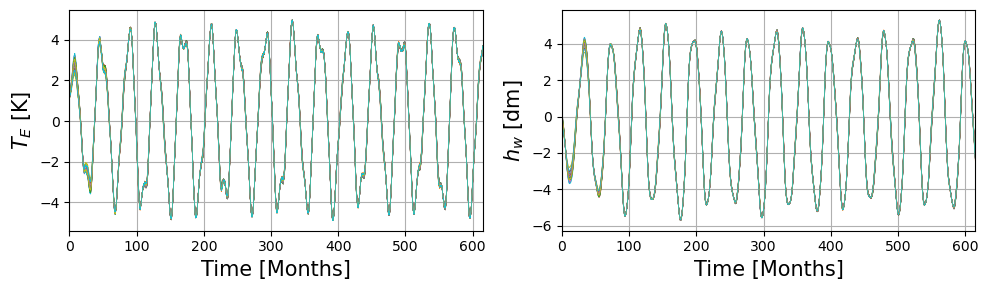

In [12]:
runSolver(numPeriods=15, dt=1/30, en=0.1, mu=0.75, windForcing=True, annualCycling=True, numEnsembles=30, pertRange=[0.5, 5.])

Figure 14: Plume diagrams for the SST anomaly and the thermocline depth after 30 different runs in the ensemble simulation.

Figure 14 shows the plume diagrams of 30 runs of the ensemble simulation, for both the SST anomaly and the thermocline depth. Despite small differences in starting points, all solutions follow the same basic oscillatory features. The trajectories for the SST anomalies have similar periods, and the amplitude of the oscillations range between approximately $\pm4$K. The same can be said for the trajectories of the thermocline depth - here the amplitudes instead range between approximately $\pm60$m. Over time, the differences between different solutions become smaller. We can therefore conclude that for these settings, the Jin model is not chaotic.



### 9. Discussion

Observed ENSO signals suggest chaotic behaviour, making prediction challenging. However, our model does not exhibit chaos. 

In Vallis (1986) it is explained that coupled systems with three dependent variables can display chaotic behaviour. Vallis demonstrated this with a simple ENSO model involving three coupled equations for the thermocline depth, SST anomaly and wind. This was also shown for the recharge oscillator model in Jin et al. (2007). In this case the linear recharge-oscillator model was adapted to include multiplicative forcing terms in both equations of the model, and it was shown under certain conditions that the solutions were able to bifurcate between two states, leading to irregularities. Our model only has two dependent variables: the SST anomaly and the thermocline depth. By adding a third variable to the our system, it may be possible to introduce sufficient complexity to observe chaos. 

Vallis also suggests that while systems with two dependent variables are ordinarily restricted to limit cycle behaviour, irregularity can be observed if time-dependent forcings are added. Our system includes a time-dependent wind forcing ($\xi_1$), but we did not observe chaotic behaviour. It is possible that this is because the stochastic term of $\xi_1$ is not large enough in our model, at least compared to the range of the perturbations of our ensemble analysis. It is also possible that including a non-zero heat forcing term $\xi_2$ with stochastic and time-dependent terms would have introduced chaos into the system.

We observed that super-critical values of the coupling parameter resulted in unstable growth while sub-critical values decayed the solution. This leads to a Hopf bifurcation from the climate state around which the model has been linearised. It is possible that adding a small amount of noise around this critical value of $\mu$ at each time step would cause the system to bifurcate and to exhibit chaotic behaviour. Additionally, since non-linearity is needed for chaos to exist, perhaps increasing the degree of non-linearity in our model may have help to achieve this.

Overall, while we were not able to initiate chaotic behaviour in the model, we were able to demonstrate that for a range of values of the coupling parameter $\mu$, the recharge oscillator can be either self-excited, or stochastically sustained with wind fluctuations. We have also shown that in the presence of non-linear relationships (such as that of the subsurface temperature and the thermocline depth), any unstable growth is limited and the system also becomes self-excited.

Ultimately, this model is a very simple physical model for ENSO, and does not capture many physical processes that occur in reality. For example, this model ignores the explicit role of wave propagation, and instead incorporates this behaviour into combined terms. While we have captured some of the observed ENSO behaviour, our model has been unable to capture the irregularity that ENSO possesses in reality.

## References

Galanti, E. and Tziperman, E. (2000). ENSO’s phase locking to the seasonal cycle in the
fast-SST, fast-wave and mixed-mode regimes. J. Atmos. Sci., 57, 2936–2950.

Jin, F.-F. (1997a). An equatorial ocean recharge paradigm for ENSO: Part I: Conceptual
model. J. Atmos. Sci., 54, 811–829.

Jin, Fei-Fei & Lin, Lin & Timmermann, Axel & Zhao, J.. (2007). Ensemble-mean dynamics of the ENSO recharge oscillator under state-dependent stochastic forcing. Geophysical Research Letters - GEOPHYS RES LETT. 34. 10.1029/2006GL027372. 

Tziperman, E., Zebiak, S. and Cane, M. (1997). Mechanisms of Seasonal – ENSO Interaction. Journal of the Atmospheric Sciences 54(1) pp. 61-71. Available at: https://journals.ametsoc.org/view/journals/atsc/54/1/1520-0469_1997_054_0061_mosei_2.0.co_2.xml [Accessed 9 Feb 2024].

Vallis, G. K. (1986). El niño: A chaotic dynamical system? Science, 232(4747), 243–245.

## Appendix (not included as part of my 6 pages please)

### A. Numerical Schemes

Definitions and details of the numerical schemes can be found in the lecture notes. Schemes where special considerations had to be taken are considered here. In the following, the discretized right-hand-side of Equation 1 is referred to as $f(h_w^n, T_E^n)$ for time step $n$, and for Equation 2 this is $g(h_w^n, T_E^n)$.
#### A.1 Modified Euler (Matsuno)

In the modified Euler scheme, we use the prediction of Equation 1 to solve Equation 2.

\begin{align}
h_w^{n+1} = h_w^n + \Delta t f(h_w^n, T_E^n)
\end{align}

\begin{align}
T_E^{n+1} = T_E^n + \Delta t g(h_w^{n+1}, T_E^n)
\end{align}

#### A.2 Trapezoidal
For the trapezoidal scheme, special consideration must be taken when dealing with the non-linear term, since the equation is no longer linear and complicates the solution of the implicit scheme matrix equation. Here we use the forward Euler scheme as a predictor step, which is then used for the non-linear term of the equation.

\begin{align}
h_w^{*} = h_w^n + \Delta t f(h_w^n, T_E^n) \\
T_E^{*} = T_E^n + \Delta t g(h_w^n, T_E^n)
\end{align}

The discretized SST anomaly equation then becomes, 

\begin{align}
\frac{T_E^{n+1} - T_E^n}{\Delta t} = RT_E^{n+1} + \gamma h_W^{n+1} - e_n (h_W^* + bT_E^*)^3 + \gamma \xi_1 + \xi_2
\end{align}

When rearranging, all terms that are not at time step $n+1$ are included in the right-hand-side of the matrix equation.

### B. Stability Analaysis

Since we are dealing with a system of two coupled equations, von Neumann stability analysis consists of observing changes in the spectral radius of a matrix $P$ (Equation 3) for varying time steps. The difficulty in this method is in obtaining an expression for the amplification matrix $P$. We begin by defining a common matrix that will be used by all schemes.

\begin{align}
A = \begin{bmatrix}
-r & \alpha b \\
\gamma & R \\
\end{bmatrix}
\end{align}

Parameter definitions are given in Jin (1997a).

#### B.1 Forward Euler Scheme

Simple enough.

\begin{align}
P = I + \Delta t A
\end{align}

#### B.2 Modified Euler Scheme (Matsuno)

We define the matrix $L_1$ such that,

\begin{align}
L_1 = 
\begin{bmatrix}
1 & 0 \\
-\Delta t \gamma & 1
\end{bmatrix}
\end{align}

and the matrix $L_2$ such that,

\begin{align}
L_2 = I + \Delta t
\begin{bmatrix}
-r & \alpha b \\
0 & R \\
\end{bmatrix}
\end{align}

The final expression for the amplification matrix is as follows.

\begin{align}
P = L_1^{-1}L_2
\end{align}


#### B.3  Trapezoidal Scheme

We define an intermediate matrix $L_1$ such that,

\begin{align}
L_1 = I - \frac{1}{2} \Delta t A
\end{align}

and a matrix $L_2$ such that,

\begin{align}
L_1 = I + \frac{1}{2} \Delta t A
\end{align}

The amplification matrix becomes,

\begin{align}
P = L_1^{-1}L_2
\end{align}

#### B.4  Heun Scheme
We define the intermediate matrix $L_1$, 

\begin{align}
L_1 = I + \Delta t A
\end{align}

The amplification matrix is,

\begin{align}
P = I + \frac{1}{2} \Delta t A (L_1 + I)
\end{align}

#### B.5  RK4 Scheme
We define intermediate matrices,

\begin{align}
L1 = A(I + \frac{1}{2} \Delta t  A)
\end{align}

\begin{align}
L2 = A(I + \frac{1}{2} \Delta t  L_1)
\end{align}

\begin{align}
L3 = A(I + \Delta t  L_2)
\end{align}

The amplification matrix can then be expressed as,

\begin{align}
P = I + \frac{\Delta t}{6} (A + 2L_1 + 2L_2 + L_3)
\end{align}